In [40]:
import numpy as np
import torch.nn as nn
import torch

### Implementing Layer Normalization using Numpy & Pytorch

In [ ]:


class LayerNorm:
    def __init__(self, feature_dim, epsilon = 1e-5):
        self.epsilon = epsilon
        ## This is for the broadcasting operation to restore the original
        self.gamma = np.ones((1, feature_dim))
        self.beta = np.zeros((1, feature_dim))

    def forward(self, x):
        ## compute mean and variance
        
        ## A key insight is, since this is Layer Normalization, 
        ## here the statistics are calculated across the features for a given sample
        ## For the issue, of difference of scale among features, Feature scaling should already have been done on the input dataset
        mean = np.mean(x, axis = -1, keepdims = True)
        ## This would yield one mean, one variance per sample
        var = np.var(x, axis = -1, keepdims = True)
        
        # Normalize
        x_hat = (x-mean)/ np.sqrt(var + self.epsilon)
        
        # Scale and Shift
        out = self.gamma * x_hat + self.beta
        return out
    


np.random.seed(42)
x = np.random.randn(3, 5)
layer_norm = LayerNorm(feature_dim = 5)
output = layer_norm.forward(x)

output

array([[ 0.05953112, -0.94285007,  0.29786028,  1.67967986, -1.09422119],
       [-0.91394636,  1.5550132 ,  0.4497398 , -1.23436916,  0.14356252],
       [ 0.48820066,  0.48539044,  1.34556226, -1.27405024, -1.04510313]])

### Implementing Layer Normalization using PyTorch

In [41]:
class CustomLayerNorm(nn.Module):
    def __init__(self, feature_dim, epsilon = 1e-5):
        super(CustomLayerNorm, self).__init__()
        self.epsilon = epsilon
        ## trainable parameters
        self.gamma = nn.Parameter(torch.ones(feature_dim))
        self.beta = nn.Parameter(torch.zeros(feature_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)

        x_hat = (x-mean) / torch.sqrt(var + self.epsilon)
        out = self.gamma * x_hat + self.beta

        return out
    
x = torch.randn(3, 5)
layer_norm_custom = CustomLayerNorm(feature_dim = 5)
output = layer_norm_custom(x)

output

tensor([[ 1.1021, -1.1830, -0.7301,  0.9173, -0.1064],
        [ 0.3102,  0.4283, -0.5087,  1.1956, -1.4255],
        [ 1.2521, -0.8476, -0.5878,  0.9137, -0.7304]], grad_fn=<AddBackward0>)

### Implementing NN with and without Layer normalization

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
print(f"Torch version: {torch.__version__}")

Torch version: 2.2.1


In [13]:
## defining the dimensions of the dataset
torch.manual_seed(42)
n_samples = 10000
n_features = 5


#### Creating synthetic data

In [16]:
X = torch.rand(n_samples, n_features) * torch.tensor([1, 10, 100, 1000, 10000], 
                                        dtype = torch.float32)

X[:, 4] = X[:, 1]**2 + X[:, 0]
X[:, 3] = X[:, 1]*2 + X[:, 0] * 3

y = X.sum(dim = 1, keepdim = True) + torch.rand(n_samples, 1) * 10
print("X.shape: ", X.shape)
print("y.shape: ", y.shape)

X.shape:  torch.Size([10000, 5])
y.shape:  torch.Size([10000, 1])


In [4]:
torch.rand(3, 5, 4).sum(dim = (1, 2), keepdims = True)

tensor([[[10.4016]],

        [[ 8.6152]],

        [[11.5268]]])

In [5]:
## performing the train-test split
train_size = int(0.8 * n_samples)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(train_size)
print(X_train.shape)
print(y_test.shape)

8000
torch.Size([8000, 5])
torch.Size([2000, 1])


### Creating a simple Neural network without Normalization

In [6]:
## Simple NN: no-layer normalization
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        ## layer 1: input layer
        self.ly1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        ## layer 2: hidden layer
        self.ly2 = nn.Linear(128, 32)
        self.relu2 = nn.ReLU()
        ## layer 3: output layer
        self.ly3 = nn.Linear(32, 1)

    def forward(self, x):
        ## layer 1: input layer
        x = self.ly1(x)
        x = self.relu1(x)
        ## layer 2: hidden layer
        x = self.ly2(x)
        x = self.relu2(x)
        ## layer 3: output layer
        x = self.ly3(x)
        return x


## Layer Normalized NN
class LayerNormNN(nn.Module):
    def __init__(self, input_dim):
        super(LayerNormNN, self).__init__()
        ## layer 1: input layer
        self.ly1 = nn.Linear(input_dim, 128)
        self.layer_norm1 = nn.LayerNorm(128)
        self.relu1 = nn.ReLU()
        ## layer 2: hidden layer
        self.ly2 = nn.Linear(128, 32)
        self.layer_norm2 = nn.LayerNorm(32)
        self.relu2 = nn.ReLU()
        ## layer 3: output layer
        self.ly3 = nn.Linear(32, 1)
    
    def forward(self, x):
        ## layer 1: input layer
        x = self.ly1(x)
        x = self.layer_norm1(x)
        x = self.relu1(x)
        ## layer 2: hidden layer
        x = self.ly2(x)
        x = self.layer_norm2(x)
        x = self.relu2(x)
        ## layer 3: output layer
        x = self.ly3(x)
        return x

        

#### Function to implement the training loop

In [7]:
def train(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs = 100):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        ## Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Computing Test Losss
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = criterion(y_test_pred, y_test)
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
    
    return train_losses, test_losses



In [8]:
## initializing the two models
model_no_norm = SimpleNN(n_features)
model_with_norm = LayerNormNN(n_features)

## Defining the optimizer and the loss functions
criterion = nn.MSELoss()
optimizer_no_norm = optim.Adam(model_no_norm.parameters(), lr = 1e-2)
optimizer_ly_norm = optim.Adam(model_with_norm.parameters(), lr = 1e-2)

## Defining the training loops
epochs = 100
train_losses_no_norm, test_losses_no_norm = train(model = model_no_norm,
                                                  optimizer = optimizer_no_norm,
                                                  criterion = criterion,
                                                  X_train = X_train, 
                                                  y_train = y_train, 
                                                  X_test = X_test, 
                                                  y_test = y_test, 
                                                  epochs = epochs)

train_losses_with_norm, test_losses_with_norm = train(model = model_with_norm,
                                                  optimizer = optimizer_ly_norm,
                                                  criterion = criterion,
                                                  X_train = X_train, 
                                                  y_train = y_train, 
                                                  X_test = X_test, 
                                                  y_test = y_test, 
                                                  epochs = epochs)



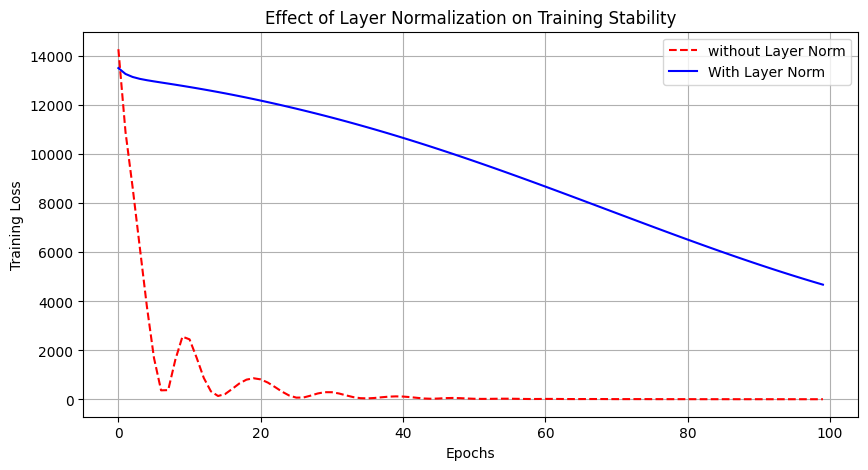

In [9]:
## Plotting the Training losses

plt.figure(figsize = (10, 5))
plt.plot(train_losses_no_norm, 

         label = "without Layer Norm", 
         linestyle = "--",
         color = "red")
plt.plot(train_losses_with_norm, 
         label = "With Layer Norm", 
         linestyle = '-', 
         color = "blue")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title("Effect of Layer Normalization on Training Stability")
plt.grid()
plt.legend()
plt.show()



In [12]:
rand_indx = np.random.randint(10000)

print(model_no_norm(X[rand_indx]))
print(model_with_norm(X[rand_indx]))

tensor([57.5879], grad_fn=<ViewBackward0>)
tensor([58.2856], grad_fn=<ViewBackward0>)


## **Conclusions from the Curve**

Based on the image, we can draw the following conclusions about the impact of **Layer Normalization** on training stability:

### **Observations:**
1. **Without Layer Normalization (Red Dashed Line)**
   - Initially, the training loss drops sharply.
   - However, it exhibits significant oscillations and instability in the early epochs.
   - Eventually, the loss stabilizes, but this erratic behavior suggests inefficient weight updates and difficulties in convergence.

2. **With Layer Normalization (Blue Line)**
   - The training loss decreases in a much smoother manner.
   - However, the rate of convergence is slower compared to the model without normalization.
   - This suggests that while layer normalization stabilizes training, it may require more epochs to reach optimal performance.

### **Conclusion:**
- **Layer Normalization improves training stability** by preventing drastic fluctuations in weight updates.
- However, it may lead to **slower convergence** initially since it normalizes feature activations, thereby controlling gradient magnitudes.
- In real-world scenarios, the benefits of stability often outweigh faster but unstable convergence, making Layer Normalization particularly useful in **deep networks and NLP models like Transformers**.

